# [EXPLORATION-14] Moivelens_Recommender_Sysyem

# 1. 데이터 준비와 전처리

## 유저가 영화에 대해 평점을 매긴 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 선호도 기준 정하기

* 평점이 3점 이상인 movie들만 남김
* 1,000,209개의 영화 중, 836,478개의 영화만 평점이 3점 이상 (약 83.63%)

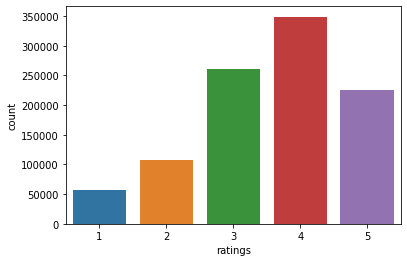

In [3]:
sns.countplot(x='ratings', data=ratings);

In [4]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


## 암묵적 평가로 지표 변경
* rating은 explicit 데이터지만 implicit 데이터로 간주

In [5]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 사용하지 않는 Col 제거

* 본 커널에서는 시간은 고려하지 않음

In [6]:
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


## 영화 메타 데이터 불러오기

In [7]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# ratings와 movies dataframe 병합

In [8]:
df_merge = pd.merge(ratings, movies, how='left', on=['movie_id'])
df_merge.head()

,user_id,movie_id,counts,title,genre
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,My Fair Lady (1964),Musical|Romance
3,1,3408,4,Erin Brockovich (2000),Drama
4,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy


## 가장 많은 장르 수 확인

In [9]:
print(max(df_merge['genre'], key=len))

Action|Animation|Children's|Sci-Fi|Thriller|War


In [10]:
df_merge[['genre_1', 'genre_2', 'genre_3','genre_4','genre_5','genre_6']] = df_merge.genre.str.split("|", expand=True)
df_merge.head()

,user_id,movie_id,counts,title,genre,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,None,None,None,None,None
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical,Animation,Children's,Musical,None,None,None
2,1,914,3,My Fair Lady (1964),Musical|Romance,Musical,Romance,None,None,None,None
3,1,3408,4,Erin Brockovich (2000),Drama,Drama,None,None,None,None,None
4,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None


# 2. 데이터 분석

## 영화 개수 확인

In [11]:
# 유니크한 영화 개수
print('number of unique movies : ', df_merge['movie_id'].nunique())

number of unique movies :  3628


## 사용자 수 확인

In [12]:
# 유니크한 사용자 수
print('number of users : ', df_merge['user_id'].nunique())

number of users :  6039


## 가장 인기 있는 영화 30개(인기순)

In [13]:
# 가장 인기 있는 영화 30개(인기순)
movie_count = df_merge.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

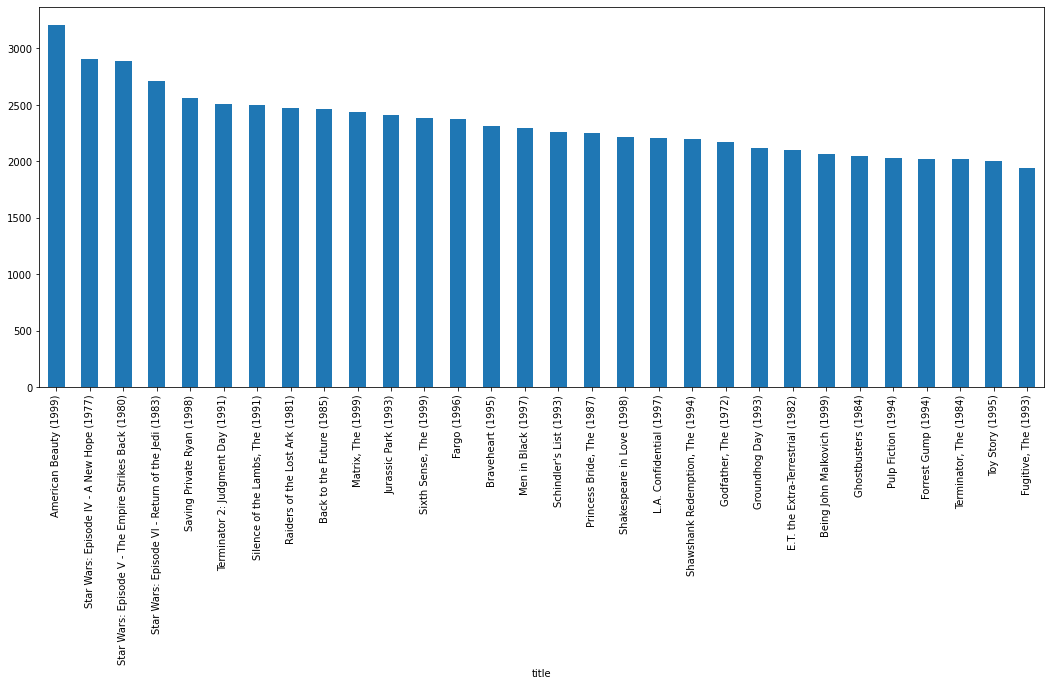

In [14]:
df_merge.groupby('title')['user_id'].count().sort_values(ascending=False).head(30).plot(kind='bar', figsize=(18,7));

# 영화별 평균 시청횟수 확인

In [15]:
movie_mean_count = pd.DataFrame(df_merge.groupby('title')['counts'].mean())
movie_mean_count.sort_values(by='counts',ascending=False).head(10)

,counts
title,
Ulysses (Ulisse) (1954),5.0
Country Life (1994),5.0
Schlafes Bruder (Brother of Sleep) (1995),5.0
Foreign Student (1994),5.0
Follow the Bitch (1998),5.0
One Little Indian (1973),5.0
Criminal Lovers (Les Amants Criminels) (1999),5.0
Message to Love: The Isle of Wight Festival (1996),5.0
Identification of a Woman (Identificazione di una donna) (1982),5.0


## 유저별 시청한 영화개수

In [16]:
user_movie_count = df_merge.groupby('user_id')['counts'].count()
user_movie_count.sort_values(ascending=False).head(10)

user_id
4169    1968
4277    1715
1680    1515
3618    1146
1015    1145
5831    1136
2909    1119
1941    1116
424     1106
1980    1054
Name: counts, dtype: int64

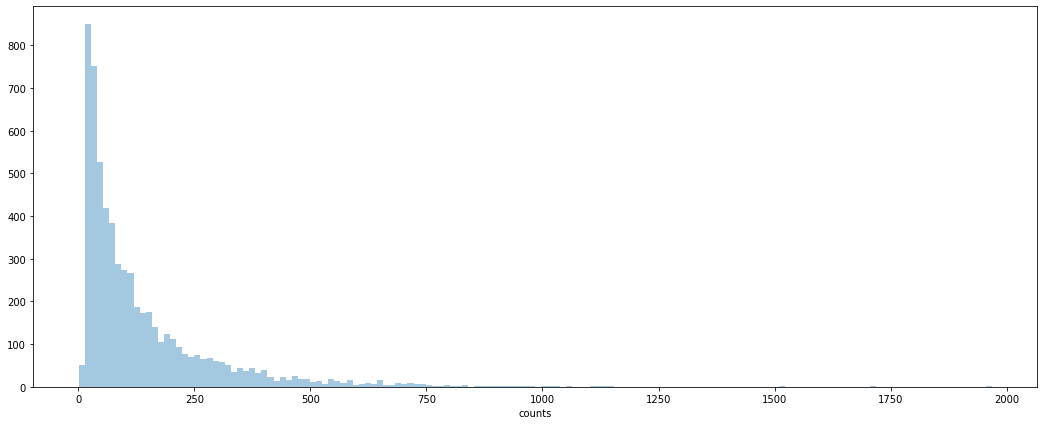

In [17]:
plt.figure(figsize=(18,7))
sns.distplot(user_movie_count, bins=150, kde=False);

## 영화를 1000개 이상본 유저 수
* 인생이 영화인 사람들인가???....(단순궁금증...)

In [18]:
user_movie_count[user_movie_count>1000].count()

15

## 유저별 영화 시청횟수

In [19]:
user_count = df_merge.groupby('user_id')['counts'].sum()
user_count.sort_values(ascending=False).head(10)

user_id
4169    7590
4277    7151
1680    6059
2909    4570
1015    4537
424     4366
3032    4336
5831    4330
1285    4279
3539    4259
Name: counts, dtype: int64

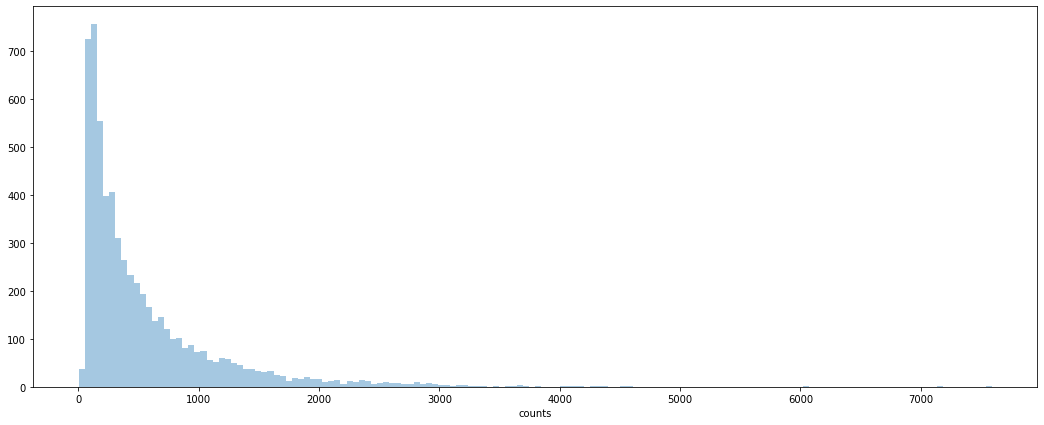

In [20]:
plt.figure(figsize=(18,7))
sns.distplot(user_count, bins=150, kde=False);

## 유저별 평균 영화 시청횟수

In [21]:
user_mean_count = df_merge.groupby('user_id')['counts'].mean()
user_mean_count.sort_values(ascending=False).head(10)

user_id
46      5.000000
283     4.962963
2339    4.956522
3902    4.914634
3324    4.904762
932     4.882353
4504    4.850000
446     4.843137
4634    4.841584
447     4.837838
Name: counts, dtype: float64

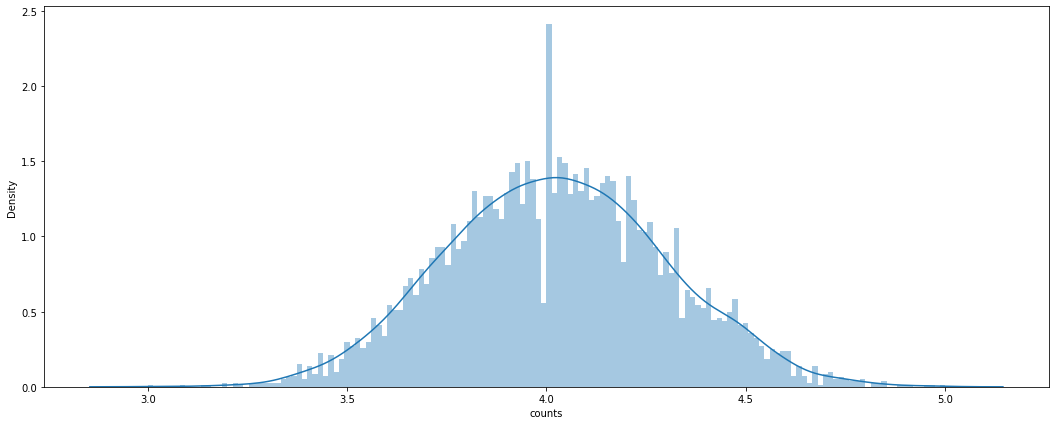

In [22]:
plt.figure(figsize=(18,7))
sns.distplot(user_mean_count, bins=150);

In [23]:
df_merge[df_merge['user_id']==4169]

,user_id,movie_id,counts,title,genre,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
579385,4169,3789,5,"Pawnbroker, The (1965)",Drama,Drama,None,None,None,None,None
579386,4169,571,4,"Wedding Gift, The (1994)",Drama,Drama,None,None,None,None,None
579387,4169,574,3,Spanking the Monkey (1994),Comedy|Drama,Comedy,Drama,None,None,None,None
579388,4169,575,3,"Little Rascals, The (1994)",Children's|Comedy,Children's,Comedy,None,None,None,None
579389,4169,577,3,Andre (1994),Adventure|Children's,Adventure,Children's,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
581348,4169,2044,3,"Devil and Max Devlin, The (1981)",Comedy,Comedy,None,None,None,None,None
581349,4169,3785,3,Scary Movie (2000),Comedy|Horror,Comedy,Horror,None,None,None,None
581350,4169,2047,3,"Gnome-Mobile, The (1967)",Children's,Children's,None,None,None,None,None
581351,4169,3788,3,Blowup (1966),Drama|Mystery,Drama,Mystery,None,None,None,None


## 장르 수 확인

In [24]:
# 유니크한 장르 수
print('number of genre : ', df_merge['genre_1'].nunique())

number of genre :  18


## 장르 종류 확인

In [25]:
# 장르의 종류
df_merge['genre_1'].unique()

array(['Drama', 'Animation', 'Musical', 'Action', 'Comedy', 'Adventure',
       'Romance', "Children's", 'Thriller', 'Crime', 'Western',
       'Documentary', 'Mystery', 'Horror', 'Sci-Fi', 'Film-Noir', 'War',
       'Fantasy'], dtype=object)

## 장르별 선호비율 확인

In [26]:
# count 하기위해 defaultdict 생성
from collections import defaultdict
import operator

genre_dict = defaultdict(int)

 # 각 장르 컬럼에 있는 값의 갯수를 모두 더함
for i in range(6):  
    genre_count = df_merge.groupby(f'genre_{i+1}')['user_id'].count()
    for name in genre_count.index:
        genre_dict[name] += genre_count[name]

genre_dict= dict(sorted(genre_dict.items(), key=operator.itemgetter(1)))
genre_dict

{'Documentary': 7162,
 'Film-Noir': 17166,
 'Western': 17668,
 'Fantasy': 29205,
 'Mystery': 34417,
 'Musical': 35661,
 'Animation': 37609,
 'Horror': 55488,
 "Children's": 57674,
 'War': 61226,
 'Crime': 68889,
 'Adventure': 108818,
 'Romance': 125927,
 'Sci-Fi': 126089,
 'Thriller': 158343,
 'Action': 209494,
 'Comedy': 293891,
 'Drama': 313261}

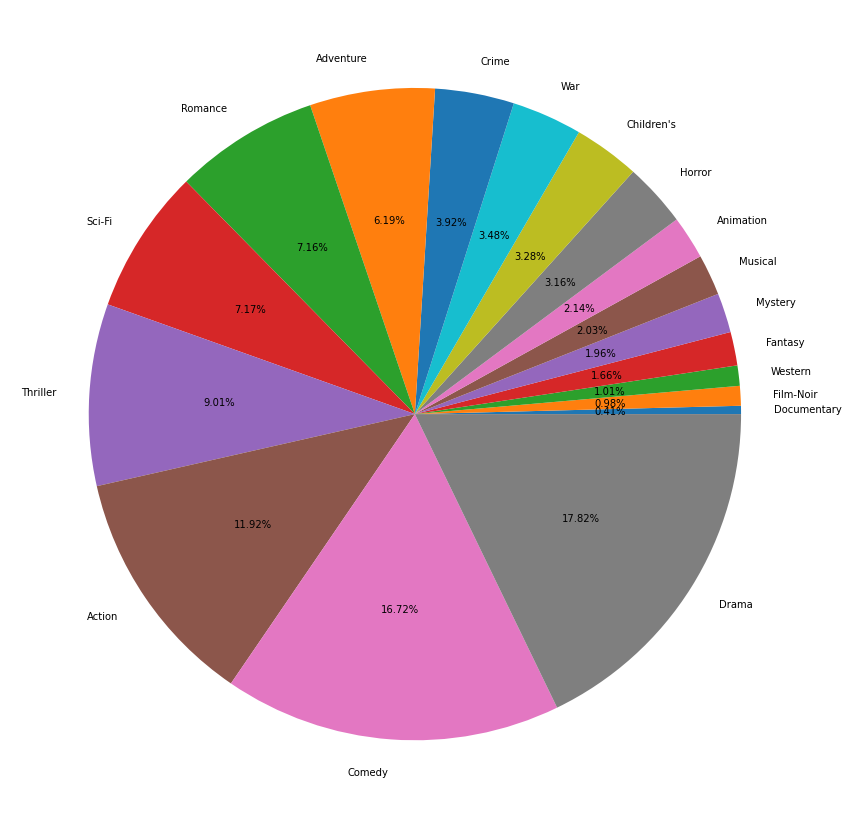

In [27]:
ratio = list(genre_dict.values())
labels = list(genre_dict.keys())

plt.figure(figsize = (15, 15))
plt.pie(ratio, labels=labels, autopct='%.2f%%')
plt.show()

# 3. 선호하는 영화 추가(모델 검증을 위한 사용자 초기 정보 세팅)

유튜브 뮤직 등 추천 시스템들은 이를 위해서 처음 가입하는 사용자의 취향과 유사한 아티스트 정보를 5개 이상 입력받는 과정을 거치게 하는 경우가 많은데, 동일한 과정이 필요하다.

## 선호하는 영화 검색
제목 검색을 위한 함수 `movie_search`를 정의한다.

In [28]:
# 제목 검색을 위해 모두 소문자로 바꿔서 검색하는 함수 생성
def movie_search(name):
    return movies[movies['title'].str.lower().str.contains(name, regex=False)]

In [29]:
movie_search('shawshank') # 쇼생크 탈출, movie_id : 318

,movie_id,title,genre
315,318,"Shawshank Redemption, The (1994)",Drama


In [30]:
movie_search('beautiful') # 인생은 아름다워, movie_id : 2324

,movie_id,title,genre
92,94,Beautiful Girls (1996),Drama
1033,1046,Beautiful Thing (1996),Drama|Romance
2255,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama
3233,3302,Beautiful People (1999),Comedy
3842,3912,Beautiful (2000),Comedy|Drama


In [31]:
movie_search('hunting') # 굿윌헌팅, movie_id : 1704

,movie_id,title,genre
1656,1704,Good Will Hunting (1997),Drama


In [32]:
movie_search('truman') # 트루먼쇼, movie_id : 1682

,movie_id,title,genre
1636,1682,"Truman Show, The (1998)",Drama


In [33]:
movie_search('river run') # 흐르는 강물처럼, movie_id : 3100

,movie_id,title,genre
3031,3100,"River Runs Through It, A (1992)",Drama


## 선호하는 영화 추가

추천시스템의 추후 검증을 위해, 데이터셋에 선호하는 영화를 5가지 골라 추가하기 위한 데이터프레임 `df_data`생성 및 데이터 추가

In [34]:
df_data = df_merge.copy()
df_data = df_data[['user_id','title', 'counts']]
df_data.tail()

,user_id,title,counts
836473,6040,Platoon (1986),3
836474,6040,"Crying Game, The (1992)",5
836475,6040,Welcome to the Dollhouse (1995),5
836476,6040,Sophie's Choice (1982),4
836477,6040,E.T. the Extra-Terrestrial (1982),4


In [35]:
# 내가 선호하는 영화 리스트
my_favorite = {'Shawshank Redemption, The (1994)': 318, 
               'Life Is Beautiful (La Vita è bella) (1997)': 2324,
               'Good Will Hunting (1997)': 1704,
               'Truman Show, The (1998)' : 1682,
               'River Runs Through It, A (1992)': 3100 }

# 'benedicto(museong)' 이라는 user_id가 위 영화를 5회 시청했다고 가정
my_favorite_df = pd.DataFrame({'user_id': ['benedicto']*5, 'title': list(my_favorite.keys()), 'counts':[5]*5})

if not df_data.isin({'user_id':['jaejun']})['user_id'].any():  # user_id에 'benedicto' 이라는 데이터가 없다면
    df_data = df_data.append(my_favorite_df)                   # 위에 임의로 만든 my_favorite 데이터를 추가 

df_data.tail(10)       # 잘 추가되었는지 확인

,user_id,title,counts
836473,6040,Platoon (1986),3
836474,6040,"Crying Game, The (1992)",5
836475,6040,Welcome to the Dollhouse (1995),5
836476,6040,Sophie's Choice (1982),4
836477,6040,E.T. the Extra-Terrestrial (1982),4
0,benedicto,"Shawshank Redemption, The (1994)",5
1,benedicto,Life Is Beautiful (La Vita è bella) (1997),5
2,benedicto,Good Will Hunting (1997),5
3,benedicto,"Truman Show, The (1998)",5
4,benedicto,"River Runs Through It, A (1992)",5


# 4. CSR Matrix 생성

## 모델 활용위한 indexing 작업
* `df_data`의 `user_id`와 `title` 컬럼 내 값들이 모두 정수 인덱스 값으로 변경

In [36]:
# 고유한 유저, 타이틀를 찾아내는 코드
user_unique = df_data['user_id'].unique()
title_unique = df_data['title'].unique()

# 유저,타이틀 indexing 하는 코드 
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

# 인덱싱이 잘 되었는지 확인
print(user_to_idx['benedicto'])    # 6040명의 유저 중 마지막으로 추가된 유저이니 6039이 나와야 함

6039


In [37]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = df_data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(df_data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    df_data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')
    
# temp_title_data을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = df_data['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(df_data):
    print('title column indexing OK!!')
    df_data['title'] = temp_title_data
else:
    print('title column indexing Fail!!')

df_data

user_id column indexing OK!!
title column indexing OK!!


,user_id,title,counts
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5
...,...,...,...
0,6039,157,5
1,6039,450,5
2,6039,248,5
3,6039,385,5


# 4. CSR(Compressed Sparse Row) Matrix 생성
* CSR Matrix는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조
* CSR Matrix는 data, indices, indptr 로 행렬을 압축하여 표현

In [38]:
from scipy.sparse import csr_matrix

num_user = df_data['user_id'].nunique()
num_movie = df_data['title'].nunique()

csr_data = csr_matrix((df_data['counts'], (df_data.user_id, df_data.title)), shape=(num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

# 5. AlternatingLeastSquares 모델 구성 및 훈련

## 모델 구성

In [39]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [40]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=15, 
                                    dtype=np.float32)

AlternatingLeastSquares 클래스의 `__init__` 파라미터

1. `factors` : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
2. `regularization` : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
3. `use_gpu` : GPU를 사용할 것인지
4. `iterations` : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

In [41]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

## 모델 훈련

In [42]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 6. 선호도 파악

## 내가 좋아하는 영화 선호도
내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해보자.

In [43]:
benedicto, shawshank = user_to_idx['benedicto'], title_to_idx['Shawshank Redemption, The (1994)']
benedicto_vector, shawshank = als_model.user_factors[benedicto], als_model.item_factors[shawshank]

In [44]:
np.dot(benedicto_vector, shawshank)

0.5329629

## 내가 좋아하는 5개 영화 중 위와 다른것 선호도

In [45]:
star = title_to_idx['Star Wars: Episode IV - A New Hope (1977)']
star_vector = als_model.item_factors[star]
np.dot(benedicto_vector, star_vector)

0.03745109

# 7. 내가 좋아하는 영화와 비슷한 영화 추천

* AlternatingLeastSquares 클래스에 구현되어 있는 `similar_items` 메서드를 통하여 비슷한 영화를 찾는다.
* 영화 이름을 입력값으로 받아서 비슷한 영화 5개를 출력해주는 `get_similar_movie` 함수를 정의

In [46]:
# index로부터 artist 이름을 얻는 dict 생성
idx_to_title = {v:k for k,v in title_to_idx.items()}

def get_similar_movie(movie_name: str):
    movie_id = title_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id, N=5)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

In [47]:
# "쇼생크 탈출"과 비슷한 영화 추천
get_similar_movie('Shawshank Redemption, The (1994)')

['Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)",
 'Pulp Fiction (1994)',
 'Fargo (1996)']

In [48]:
# "인생은 아름다워"와 비슷한 영화 추천
get_similar_movie('Life Is Beautiful (La Vita è bella) (1997)')

['Life Is Beautiful (La Vita è bella) (1997)',
 'Dinner Game, The (Le Dîner de cons) (1998)',
 'As Good As It Gets (1997)',
 'Smoke Signals (1998)',
 'Misérables, Les (1998)']

In [49]:
# "굿 윌 헌팅"과 비슷한 영화 추천
get_similar_movie('Good Will Hunting (1997)')

['Good Will Hunting (1997)',
 'Shawshank Redemption, The (1994)',
 'Apollo 13 (1995)',
 'Truman Show, The (1998)',
 'Dead Man Walking (1995)']

In [50]:
# "트루먼 쇼"와 비슷한 영화 추천
get_similar_movie('Truman Show, The (1998)')

['Truman Show, The (1998)',
 'Quiz Show (1994)',
 'Apollo 13 (1995)',
 'People vs. Larry Flynt, The (1996)',
 'Good Will Hunting (1997)']

In [51]:
# "흐르는 강물처럼"과 비슷한 영화 추천
get_similar_movie('River Runs Through It, A (1992)')

['River Runs Through It, A (1992)',
 'Philadelphia (1993)',
 'Fried Green Tomatoes (1991)',
 'Scent of a Woman (1992)',
 "What's Eating Gilbert Grape (1993)"]

# 8. 유저가 좋아하는 영화 추천

* AlternatingLeastSquares 클래스에 구현되어 있는 `recommend` 메서드를 통하여 제가 좋아할 만한 아티스트를 추천받는다.
* filter_already_liked_items 는 유저가 이미 평가한 아이템은 제외하는 Argument

In [52]:
user = user_to_idx['benedicto']

# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)

# 인덱스를 영화 이름으로 mapping
[idx_to_title[i[0]] for i in movie_recommended]

["Schindler's List (1993)",
 'Apollo 13 (1995)',
 'Saving Private Ryan (1998)',
 'Dead Man Walking (1995)',
 'Pulp Fiction (1994)',
 'October Sky (1999)',
 'Silence of the Lambs, The (1991)',
 'Awakenings (1990)',
 'Fargo (1996)',
 'Quiz Show (1994)',
 'Jerry Maguire (1996)',
 'Sling Blade (1996)',
 'GoodFellas (1990)',
 "What's Eating Gilbert Grape (1993)",
 "Mr. Holland's Opus (1995)",
 'Elizabeth (1998)',
 'Trainspotting (1996)',
 'As Good As It Gets (1997)',
 'Scent of a Woman (1992)',
 'Few Good Men, A (1992)']

* Schindler's List (1993)를 추천해 주고 있다.
* AlternatingLeastSquares 클래스에 구현된 `explain` 메서드를 사용하면 제가 기록을 남긴 데이터 중 이 추천에 기여한 정도를 확인할 수 있다.
* 이 method는 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠와 기여도(합이 콘텐츠의 점수가 됩니다.)를 반환한다.

In [53]:
schindler = title_to_idx["Schindler's List (1993)"]
explain = als_model.explain(user, csr_data, itemid=schindler)

[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('Shawshank Redemption, The (1994)', 0.31597984756966563),
 ('Good Will Hunting (1997)', 0.10127878999497586),
 ('Life Is Beautiful (La Vita è bella) (1997)', 0.058914676043228746),
 ('River Runs Through It, A (1992)', -0.0015894435965954341),
 ('Truman Show, The (1998)', -0.02752551678882783)]

# 9. 하이퍼파라미터 조정

In [54]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=300, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=50, 
                                    dtype=np.float32)

In [55]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [56]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/50 [00:00<?, ?it/s]

In [57]:
# 내가 좋아하는 영화 선호도
benedicto, shawshank = user_to_idx['benedicto'], title_to_idx['Shawshank Redemption, The (1994)']
benedicto_vector, shawshank = als_model.user_factors[benedicto], als_model.item_factors[shawshank]

np.dot(benedicto_vector, shawshank)

0.8297026

In [58]:
# 내가 좋아하지 않는 영화 선호도
star = title_to_idx['Star Wars: Episode IV - A New Hope (1977)']
star_vector = als_model.item_factors[star]
np.dot(benedicto_vector, star_vector)

0.079139955

In [60]:
# "인생은 아름다워"와 비슷한 영화 추천
get_similar_movie('Life Is Beautiful (La Vita è bella) (1997)')

['Life Is Beautiful (La Vita è bella) (1997)',
 'Misérables, Les (1998)',
 'Waking Ned Devine (1998)',
 'Other Side of Sunday, The (Søndagsengler) (1996)',
 'Very Thought of You, The (1998)']

In [61]:
# 유저가 좋아하는 영화 추천
user = user_to_idx['benedicto']

# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)

# 인덱스를 영화 이름으로 mapping
[idx_to_title[i[0]] for i in movie_recommended]

['Awakenings (1990)',
 'Apollo 13 (1995)',
 'Fried Green Tomatoes (1991)',
 'Scent of a Woman (1992)',
 'Jerry Maguire (1996)',
 'October Sky (1999)',
 'Dead Man Walking (1995)',
 "Schindler's List (1993)",
 'Wag the Dog (1997)',
 "What's Eating Gilbert Grape (1993)",
 'Fargo (1996)',
 'Almost Famous (2000)',
 'Three Kings (1999)',
 'Contact (1997)',
 'Sliding Doors (1998)',
 'Sling Blade (1996)',
 'Planet of the Apes (1968)',
 'On Golden Pond (1981)',
 'Postino, Il (The Postman) (1994)',
 'Edward Scissorhands (1990)']

In [63]:
# 이 추천에 기여한 정도 확인
schindler = title_to_idx["Awakenings (1990)"]
explain = als_model.explain(user, csr_data, itemid=schindler)

[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('River Runs Through It, A (1992)', 0.0731608707872363),
 ('Truman Show, The (1998)', 0.05119748390779956),
 ('Life Is Beautiful (La Vita è bella) (1997)', 0.03945182707490799),
 ('Shawshank Redemption, The (1994)', 0.03819468147371542),
 ('Good Will Hunting (1997)', 0.03545162120185319)]

# 프로젝트 정리


# 내가 선호하는 5가지 영화 장르


| 영화 이름 | 장르 |
|:--- | :--- |
| `Shawshank Redemption, The (1994)` | `Drama` |
| `Life Is Beautiful (La Vita è bella) (1997)` | `Drama` |
| `Good Will Hunting (1997)` | `Drama` |
| `Truman Show, The (1998)` | `Drama` |
| `River Runs Through It, A (1992)` | `Drama` |


막상 프로젝트를 끝내니 좋아하는 영화들의 장르가 전부 드라마 장르다.

<br>

# 선호도 파악

* 기본 baseline model로 학습결과(factors=100, regularization=0.01, use_gpu=False, iterations=15)

| 내적 | 결과 |
|:--- | :--- |
| `benedicto`와 `쇼생크탈출`을 내적한 결과 | `0.5329629` |
| `benedicto`와 `스타워즈`를 내적한 결과 | `0.03745109` |

* 파라미터 조정 model로 학습결과(factors=300, regularization=0.01, use_gpu=False, iterations=50)

| 내적 | 결과 |
|:--- | :--- |
| `benedicto`와 `쇼생크탈출`을 내적한 결과 | `0.8297026` |
|`benedicto`와 `스타워즈`를 내적한 결과 | `0.079139955` |


`factors`, `iterations`를 증가시켜 학습 후 테스트를 해보니 내가 선호하는 영화 중 하나인 `쇼생크탈출`에 대해 모델이 예측한 나의 선호도는 대폭 상승하고, 선호하지 않은 영화 중 하나인 `스타워즈`에 대해 선호도가 소폭 상승했다.

<br>


# 내가 좋아할만한 영화 추천

다음은 추천알고리즘이 추천한 내가 좋아할만한 영화 TOP5 이다. 파라미터 전과 후로 나누어 비교한다.

* 기본 baseline model로 학습결과(factors=100, regularization=0.01, use_gpu=False, iterations=15)

| 영화제목 | 장르 |
|:--- | :--- |
| `Schindler's List (1993)` | `Drama`, `War` |
| `Apollo 13 (1995)` | `Drama` |
| `Saving Private Ryan (1998)` | `Action`, `Drama`, `War` |
| `Dead Man Walking (1995)` | `Drama` |
| `Pulp Fiction (1994)` | `Crime`, `Drama` |

* 파라미터 조정 model로 학습결과(factors=300, regularization=0.01, use_gpu=False, iterations=50)
| 영화제목 | 장르 |
|:--- | :--- |
| `Awakenings (1990)` | `Drama` |
| `Apollo 13 (1995)` | `Drama` |
| `Fried Green Tomatoes (1991)` | `Drama` |
| `Scent of a Woman (1992)` | `Drama` |
| `Jerry Maguire (1996)` | `Drama`, `Romance` |

나쁘지 않은 결과다. 전부 한번씩 본 영화들로 재미있게 본 기억이 있다.

<br>

# 회고

일상생활 속에서 대부분의 사람들은 추천시스템을 적용한 제품을 사용하는데 추천알고리즘 자체에 대한 궁금증이 있었는데 해당 노드를 통해서 추천의 시발점을 경험한 것 같다. 다만 노드 프로젝트를 하면서 너무 단순하게만 진행되었다는 점이다. 사람들의 선호도는 복잡성이 존재 할 뿐만 아니라 다양성까지 존재하므로 굉장히 고려해야할 것들이 많으며 더 아이러니한것은, 사람들이 살아가면서 정작 자신이 무엇을 좋아하는지 인지도 못한다는 것이다. 이러한 의미에서 추천은 굉장히 어려운 영역이지 않나 생각된다. 그럼에도 불구하고 매력적이다 라고 생각된다.